### Performance Evaluation: AP scores ###

In [9]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torchvision import ops

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics
from computervision.inference import DETR

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [10]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey', offset_xy=(0, 0)):
    offset_xy = (10 + offset_xy[0], 100 + offset_xy[1])
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Test data ###

In [4]:
# HSDM DATA
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_240921')
df_file_name = 'objectdata_240921_clean_ide.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file
0,457fecca_20180208_00.png,20,0.565375,"[0.0, 453.28, 267.08, 865.22]",457fecca,Maria,2,2,2,3,2,0,stable,yes,box_457fecca_20180208_00_00.png
1,8fb6f1a1_20220322_00.png,3,0.989590,"[0.0, 69.95, 501.94, 892.3]",8fb6f1a1,Maria,3,2,3,3,2,3,healthy,yes,box_8fb6f1a1_20220322_00_02.png


In [5]:
# Dentex testing data
image_dir = os.path.join(os.environ.get('DATA'), 'dentex_detection_250928', 'test')
df_file_name = 'train_quadrant_enumeration_test_set.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
df = df.loc[(df['dset'] == 'test') & (df['transformation'] == 2)]
display(df.head(2))

file_col = 'file_name'
pos_col = 'ada'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
11230,"[589, 0, 45, 306]",1.0,8.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test
11231,"[527, 0, 91, 306]",1.0,7.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test


In [11]:
# Roboflow test data
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_roboflow_240930')
df_file_name = 'roboflow_240930.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))
# What are the categories in this data set
print(list(df['category'].unique()))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

# Let's get rid of the rows that do not have locations
df = df.loc[~df[pos_col].isnull()]

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)
print(f'Using {len(checked)} images from the Roboflow data set')
print(f'Annotations: {df.shape[0]}')

,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
0,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[381.0, 242.0, 481.474, 279.948]",composite,composite,NaN,40762886f4_0
1,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[8.0, 0.0, 130.293, 176.736]",tooth 23,teeth,11.0,40762886f4_1


['composite', 'tooth 23', 'tooth 25', 'tooth 26', 'tooth 27', 'tooth 33', 'tooth 34', 'tooth 35', 'tooth 36', 'tooth 37', 'tooth 17', 'tooth 16', 'tooth 15', 'tooth 46', 'tooth 47', 'caries', 'tooth 24', 'Calculus', 'root filling', 'crown', 'tooth 45', 'tooth 44', 'tooth 14', 'tooth 18', 'tooth 48', 'tooth 13', 'tooth 43', 'tooth 28', 'tooth 38', 'tooth 12', 'amalgam', 'implant', 'tooth 22', 'periapical pathology', 'tooth 32']
Using 991 images from the Roboflow data set
Annotations: 8788


### Model and image processor ###

In [13]:
model_name = 'rtdetr_251001_02'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

checkpoint_name = 'checkpoint-17500'
checkpoint = os.path.join(model_dir, checkpoint_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())

# Category ID to label conversion
id2label = model_parameters.get('id2label')
id2label = {int(k): int(v) for k,v in id2label.items()}

# Load the model
dtr = DETR(checkpoint_path=checkpoint)

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0


### Predict on an image ###

True: [16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 17.0, 18.0, 19.0, 20.0, 21.0]
Pred: [16, 13, 19, 20, 17, 18, 12]


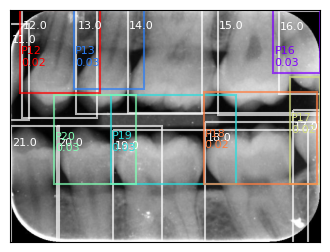

In [18]:
figsize = (4, 4)
threshold = 0.02
idx = 123
file_name = file_name_list[idx]
    
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
df_file = df.loc[df[file_col] == file_name]
bbox_list = df_file[bbox_col].tolist()
pos_list = df_file[pos_col].tolist()
    
# Predict positions
output = dtr.predict(image=im, threshold=threshold)
if output is not None:
    output_bbox_list = output.get('bboxes')
    output_cat_list = output.get('categories')
    output_pos_list = [id2label.get(cat) for cat in output_cat_list]
    score_list = output.get('scores')
    output_label_list = [f'P{p}\n{s:.2f}' for p, s in zip(output_pos_list, score_list)]

    print(f'True: {pos_list}')
    print(f'Pred: {output_pos_list}')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
    ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_label_list, ax=ax, offset_xy=(0, 200))
    plt.show()

[554, 3, 86, 170]
16
[543, 0, 96, 131]


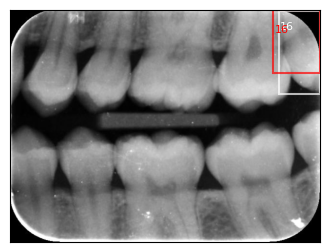

IoU for label 16: 0.6668301224708557


In [20]:
# Let's pick one ground truth and one predicted position
# So we can calculate the iou
true_pos = 16
true_bbx = list(bbox_list[pos_list.index(true_pos)])
true_bbx = clipxywh(true_bbx, xlim=x_lim, ylim=y_lim, decimals=0)
print(true_bbx)

pred_pos_idx = output_pos_list.index(true_pos)
pred_pos = output_pos_list[pred_pos_idx]
print(pred_pos)
pred_bbx = output_bbox_list[pred_pos_idx]
print(pred_bbx)

# Plot this situation
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=[true_bbx], label_list=[true_pos], ax=ax, color='w')
ax = plot_boxes(image=im, box_list=[pred_bbx], label_list=[pred_pos], ax=ax, color='r', offset_xy=(0, 20))
plt.show()

# Calculate the IoU for the predicted bounding box and the ground truth
iou = DetectionMetrics.compute_iou(bbox_1=true_bbx, bbox_2=pred_bbx, bbox_format='xywh', method='pt')
print(f'IoU for label {true_pos}: {iou}')

True labels:        [16, 15, 14, 13, 12, 11, 17, 18, 19, 20, 21]
Pred labels:        [16, 13, 19, 20, 17, 18, 12]
Missed predictions: [11, 14, 15, 21]
Prediction for label 1/7: 16: TP with IoU: 0.6668301224708557


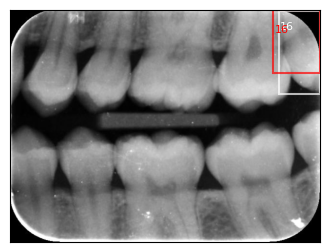

Prediction for label 2/7: 13: FP with IoU: 0.40318021178245544


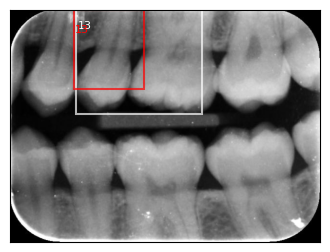

Prediction for label 3/7: 19: FP with IoU: 0.24696506559848785


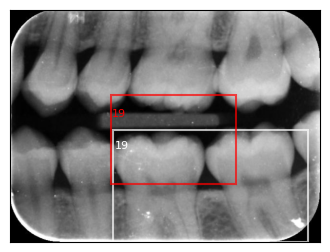

Prediction for label 4/7: 20: FP with IoU: 0.3040419816970825


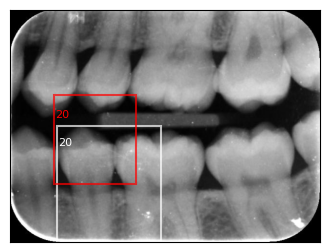

Prediction for label 5/7: 17: FP with IoU: 0.41009828448295593


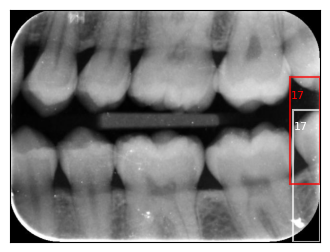

Prediction for label 6/7: 18: FP with IoU: 0.3972296714782715


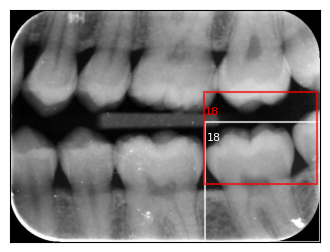

Prediction for label 7/7: 12: TP with IoU: 0.7258310317993164


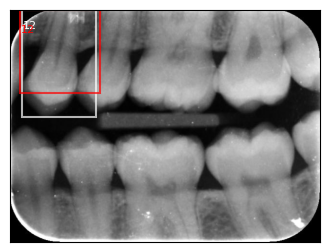

[16, 13, 19, 20, 17, 18, 12]
[16, 15, 14, 13, 12, 11, 17, 18, 19, 20, 21]
[0.6668301224708557, 0.40318021178245544, 0.24696506559848785, 0.3040419816970825, 0.41009828448295593, 0.3972296714782715, 0.7258310317993164]
['TP', 'FP', 'FP', 'FP', 'FP', 'FP', 'TP']


,pred_label,TP,score,IoU,duplicate_TP
0,16,TP,0.0302,0.666830,False
1,13,FP,0.0276,0.403180,False
2,19,FP,0.0266,0.246965,False
3,20,FP,0.0256,0.304042,False
4,17,FP,0.0231,0.410098,False
5,18,FP,0.0212,0.397230,False
6,12,TP,0.0202,0.725831,False


In [22]:
# Performance evaluations
score_threshold = 0.02
iou_threshold = 0.5

# Ground truth
true_labels = [int(l) for l in df_file[pos_col].tolist()]
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]
print(f'True labels:        {true_labels}')

# Predictions
output = dtr.predict(image=im, threshold=score_threshold)
pred_labels = [int(id2label.get(cat)) for cat in output.get('categories')]
pred_bboxes = output.get('bboxes')
pred_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in pred_bboxes]
pred_scores = output.get('scores')
print(f'Pred labels:        {pred_labels}')

# Determine the false negative samples
# Predictions that were missed by the object detection
missed = sorted(list(set(true_labels).difference(pred_labels)))
print(f'Missed predictions: {missed}')

# We want to classify the predictions
iou_list = []
prediction_list = []
for p, p_label in enumerate(pred_labels):
    
    p_bbox = pred_bboxes[p]
    
    # When there is no label for this prediction, it is a FP prediction
    # NOTE: the FP numbers will be too high if not all of the instances are labeled!
    p_prediction = 'FP'
    p_iou = np.nan
    
    # Let's check each ground truth labels if we have a match
    pt_iou_list = []
    t_bbx_list = []
    
    for t, t_label in enumerate(true_labels):
        if p_label == t_label:
            t_bbox = true_bboxes[t]
            pt_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
            pt_iou_list.append(pt_iou)
            t_bbx_list.append(t_bbox)
            
    if len(pt_iou_list) > 0:
        p_iou = np.max(pt_iou_list)
        t_bbx = t_bbx_list[np.argmax(pt_iou_list)]
        if p_iou >= iou_threshold:
            p_prediction = 'TP'
        
        print(f'Prediction for label {p + 1}/{len(pred_labels)}: {p_label}: {p_prediction} with IoU: {p_iou}')
        
        # Plot the situation when we have a match
        fig, ax = plt.subplots(figsize=figsize)
        ax = plot_boxes(image=im, box_list=[t_bbx], label_list=[p_label], ax=ax, color='w')
        ax = plot_boxes(image=im, box_list=[p_bbox], label_list=[p_label], ax=ax, color='r', offset_xy=(0, 20))
        plt.show()

    iou_list.append(p_iou)
    prediction_list.append(p_prediction)

# What if we predict the same class twice and both are TP?
# We count only the first one as a TP, the others we set to FP.
c = pd.DataFrame({'pred_label': pred_labels,
                  'TP': prediction_list,
                  'score': pred_scores,
                  'IoU': iou_list})

c = c.assign(duplicate_TP=False)

# Flip duplicate TP predictions
d = c.copy()
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'TP'] = 'FP'
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'duplicate_TP'] = True

print(pred_labels)
print(true_labels)
print(iou_list)
print(prediction_list)
display(d)

### Prediction classification method ###

In [23]:
print(f'True labels: {true_labels}')
print(f'Pred labels: {pred_labels}')

missed, predictions_df = DetectionMetrics.\
    classify_predictions(true_labels=true_labels, 
                         true_bboxes=true_bboxes, 
                         pred_labels=pred_labels, 
                         pred_bboxes=pred_bboxes, 
                         iou_threshold=iou_threshold)

print(missed)
display(predictions_df)

True labels: [16, 15, 14, 13, 12, 11, 17, 18, 19, 20, 21]
Pred labels: [16, 13, 19, 20, 17, 18, 12]
[11, 14, 15, 21]


,pred_label,TP,IoU,FN,duplicate_TP
0,16,1,0.666830,4,False
1,13,0,0.403180,4,False
2,19,0,0.246965,4,False
3,20,0,0.304042,4,False
4,17,0,0.410098,4,False
5,18,0,0.397230,4,False
6,12,1,0.725831,4,False


True: [16, 15, 14, 13, 12, 11, 17, 18, 19, 20, 21]
Pred: [16, 13, 19, 20, 17, 18, 12]
Missed: [11, 14, 15, 21]


,pred_label,TP,IoU,FN,duplicate_TP
0,16,1,0.666830,4,False
1,13,0,0.403180,4,False
2,19,0,0.246965,4,False
3,20,0,0.304042,4,False
4,17,0,0.410098,4,False
5,18,0,0.397230,4,False
6,12,1,0.725831,4,False


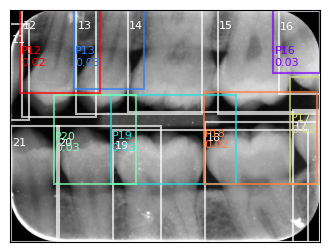

In [29]:
# Run inference on the entire data set
figsize = (4, 4)
score_threshold = 0.02
iou_threshold = 0.5

idx = 123
file_name = file_name_list[idx]
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
x_lim = (0, im.shape[1])
y_lim = (0, im.shape[0])
df_file = df.loc[df[file_col] == file_name]
bbox_list = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in df_file[bbox_col].tolist()]
pos_list = [int(pos) for pos in df_file[pos_col].tolist()]
    
# Prediction
output = dtr.predict(image=im, threshold=score_threshold)
if output is not None:
    output_bbox_list = output.get('bboxes')
    output_cat_list = output.get('categories')
    output_pos_list = [id2label.get(cat) for cat in output_cat_list]
    score_list = output.get('scores')
    output_label_list = [f'P{p}\n{s:.2f}' for p, s in zip(output_pos_list, score_list)]

    print(f'True: {pos_list}')
    print(f'Pred: {output_pos_list}')

    # Classify predictions
    missed, pred_df = DetectionMetrics.classify_predictions(true_labels=pos_list,
                                                            true_bboxes=bbox_list,
                                                            pred_labels=output_pos_list,
                                                            pred_bboxes=output_bbox_list)
    print(f'Missed: {missed}')
    display(pred_df)

    # Calculate precision/recall
    
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
    ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_label_list, ax=ax, offset_xy=(0, 200))
    plt.show()